# Devanagari Character Recognition Script

## Extract Images into a Dataset

In [1]:
import os

import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

%matplotlib inline


root_dir = os.getcwd()
img_dir = os.path.join(root_dir, 'images')

pixels = np.array(['pixel_{:04d}'.format(x) for x in range(1024)])
flag = True

for char_name in sorted(os.listdir(img_dir)):
    char_dir = os.path.join(img_dir, char_name)
    img_df = pd.DataFrame(columns=pixels)
    
    for img_file in sorted(os.listdir(char_dir)):
        image = pd.Series(imread(os.path.join(char_dir, img_file)).flatten(), index=pixels)
        img_df = img_df.append(image.T, ignore_index=True)
        
    img_df = img_df.astype(np.uint8)
    img_df['character'] = char_name
    
    img_df.to_csv('data.csv', index=False, mode='a', header=flag)
    flag=False
    
    print('=', end='')
    
    
df = pd.read_csv('data.csv')

df['character_class'] = LabelEncoder().fit_transform(df.character)
df.drop('character', axis=1, inplace=True)
df = df.astype(np.uint8)

## Algorithm Selection Using a Dataset Sample

In [2]:
df_sample = df.sample(frac=0.1, random_state=0)

names = ['RidgeClassifier', 'BernoulliNB', 'GaussianNB', 'ExtraTreeClassifier', 'DecisionTreeClassifier',
         'NearestCentroid', 'KNeighborsClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier']
classifiers = [RidgeClassifier(), BernoulliNB(), GaussianNB(), ExtraTreeClassifier(), DecisionTreeClassifier(),
                NearestCentroid(), KNeighborsClassifier(), ExtraTreesClassifier(), RandomForestClassifier()]
test_scores, train_scores, fit_time, score_time = [], [], [], []

for clf in classifiers:
    scores = cross_validate(clf, df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
    test_scores.append(scores['test_score'].mean())
    train_scores.append(scores['train_score'].mean())
    fit_time.append(scores['fit_time'].mean())
    score_time.append(scores['score_time'].mean())

pd.DataFrame({'Classifier': names,
              'Test_Score': test_scores,
              'Train_Score': train_scores,
              'Fit_Time': fit_time,
              'Score_Time': score_time})

,Classifier,Fit_Time,Score_Time,Test_Score,Train_Score
0,RidgeClassifier,0.694055,0.018355,0.423384,0.841250
1,BernoulliNB,0.115145,0.053828,0.512742,0.546638
2,GaussianNB,0.164446,1.247284,0.396972,0.433721
3,ExtraTreeClassifier,0.098612,0.010459,0.311093,1.000000
4,DecisionTreeClassifier,4.072366,0.007965,0.365119,1.000000
5,NearestCentroid,0.100165,0.027360,0.530247,0.568857
6,KNeighborsClassifier,0.668098,35.745628,0.721442,0.841367
7,ExtraTreesClassifier,0.534121,0.029591,0.574804,1.000000
8,RandomForestClassifier,0.904359,0.027685,0.543047,0.997936


## Parameter Tuning using GridSearch

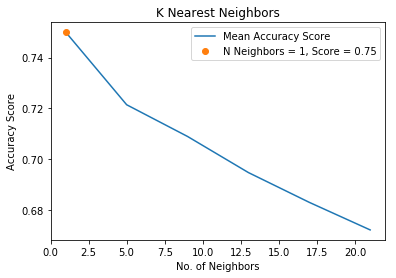

In [3]:
# K Nearest Neighbors
parameters = {'n_neighbors': np.arange(1, 22, 4)}
clf = GridSearchCV(KNeighborsClassifier(), parameters)

clf.fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
result = pd.DataFrame.from_dict(clf.cv_results_)

x, y = clf.best_params_['n_neighbors'], clf.best_score_
text = 'N Neighbors = {}, Score = {}'.format(x, y)

plt.figure()
plt.title('K Nearest Neighbors')
plt.xlabel('No. of Neighbors')
plt.ylabel('Accuracy Score')
plt.yticks(np.arange(0.6, 0.81, 0.02))

plt.plot(result.param_n_neighbors, result.mean_test_score, label='Mean Accuracy Score')
plt.plot(x, y, 'o', label=text)

plt.legend()

plt.savefig('plots/knn.png', dpi=300)

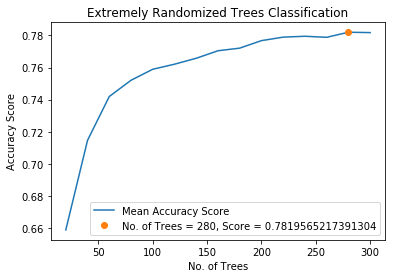

In [4]:
# Extremely Randomized Trees
parameters = {'n_estimators': np.arange(20, 310, 20)}
clf = GridSearchCV(ExtraTreesClassifier(), parameters)

clf.fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
result = pd.DataFrame.from_dict(clf.cv_results_)

x, y = clf.best_params_['n_estimators'], clf.best_score_
text = 'No. of Trees = {}, Score = {}'.format(x, y)

plt.figure()
plt.title('Extremely Randomized Trees Classification')
plt.xlabel('No. of Trees')
plt.ylabel('Accuracy Score')
plt.yticks(np.arange(0.6, 0.81, 0.02))

plt.plot(result.param_n_estimators, result.mean_test_score, label='Mean Accuracy Score')
plt.plot(x, y, 'o', label=text)

plt.legend()

plt.savefig('plots/extra-trees.png', dpi=300)

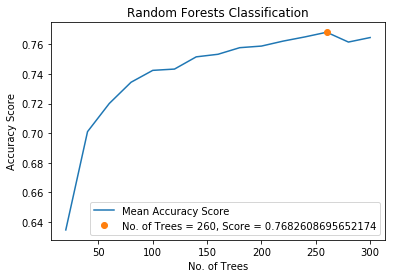

In [5]:
# Random Forests
parameters = {'n_estimators': np.arange(20, 310, 20)}
clf = GridSearchCV(RandomForestClassifier(), parameters)

clf.fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
result = pd.DataFrame.from_dict(clf.cv_results_)

x, y = clf.best_params_['n_estimators'], clf.best_score_
text = 'No. of Trees = {}, Score = {}'.format(x, y)

plt.figure()
plt.title('Random Forests Classification')
plt.xlabel('No. of Trees')
plt.ylabel('Accuracy Score')
plt.yticks(np.arange(0.6, 0.81, 0.02))

plt.plot(result.param_n_estimators, result.mean_test_score, label='Mean Accuracy Score')
plt.plot(x, y, 'o', label=text)

plt.legend()

plt.savefig('plots/random-forests.png', dpi=300)

## Learning Curve Using Extremely Randomised Decision Trees Classification

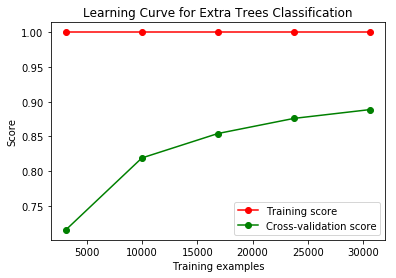

In [6]:
df_sample = df.sample(frac=0.5, random_state=0)

clf = ExtraTreesClassifier(n_estimators=256)

train_sizes, train_scores, test_scores = learning_curve(clf, df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.title('Learning Curve for Extra Trees Classification')
plt.xlabel('Training examples')
plt.ylabel('Score')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend()

plt.savefig('plots/learning-curve.png', dpi=300)

## Final Result

In [7]:
df_sample = df.sample(frac=0.5, random_state=0)

clf = ExtraTreesClassifier(n_estimators=256)

scores = cross_validate(clf, df.iloc[:, :-1], df.iloc[:, -1])
print('Mean Accuracy Score:', scores['test_score'].mean())

Mean Accuracy Score: 0.917718383268
